<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
%cd ../

/


In [ ]:
%cd content/

/content


In [2]:
!rm -rf ProjectMLDL

In [ ]:
!ls

sample_data


In [3]:
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 58 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (58/58), done.
/content/ProjectMLDL


In [4]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [6]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


classe: 90


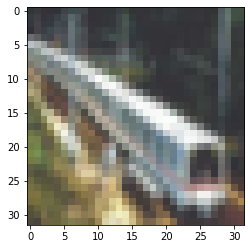

In [7]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

In [7]:
RANDOM_SEED = [42,13,10]
# Settings
DEVICE = 'cuda'

NUM_CLASSES = 100       # Total number of classes

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 64        # Batch size
LR = 2                  # Initial learning rate
                       
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2             # Gamma factor from iCaRL

In [ ]:
criterion = nn.CrossEntropyLoss()

## Training Larocca

In [ ]:
class FineTuning(nn.Module):
  def __init__(self, n_classes):
    super(FineTuning, self).__init__()
    self.feature_extractor = resnet32()
    self.n_classes = n_classes
    self.n_known = 0
    self.p = self.parameters()
    self.fc = nn.Linear(10, n_classes, bias = True)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.fc(x)
    return x

  def increment_classes(self, n):
    in_features = self.feature_extractor.in_features
    out_features = self.fc.out_features
    weight = self.fc.weight.data
    bias = self.fc.bias.data

    self.fc = nn.Linear(in_features, out_features+n, bias=True)
    self.fc.weight.data[:out_features] = weight
    self.fc.bias.data[:out_features] = bias
    self.n_classes += n


In [ ]:
train_dataloader = [[] for i in range(len(RANDOM_SEED))]
test_dataloader = [[] for i in range(len(RANDOM_SEED))]

best_acc = []
tot_matrix = []
tot_labe = []

#net = FineTuning(10)
net = resnet32()


for run_i in range(len(RANDOM_SEED)):
  random_state = RANDOM_SEED[run_i]
  subset_train = []
  subset_test = []

  train_data.__shuffle_seed__(RANDOM_SEED[run_i])
  test_data.__shuffle_seed__(RANDOM_SEED[run_i])

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

  train_dataloader = []
  test_dataloader = []

  for i in range(10):
    train_dataset = Subset(train_data, indexes_train_data[i])
    subset_train.append(train_dataset) #[[train0],[train1],...]
    train_dataloader=DataLoader(subset_train[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)
    
    test_dataset = Subset(test_data, indexes_test_data[i])
    subset_test.append(test_dataset) #[[train0],[train1],...]
    test_dataloader=DataLoader(subset_test[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)
    net.cuda()
    if(i!=0):
      net.addOutputNodes(10)
      
    net.train()
    
    p = net.parameters()
    optimizer = optim.SGD(p, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

    matrix = []
    labe = []    
    b_ac = 0
    #Training

    for epoch in range(0, NUM_EPOCHS):
      running_corrects = 0
      total = 0

      for indices, images, labels in train_dataloader:
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        indices = indices.cuda()
        optimizer.zero_grad()
        g = net(images)
        #print(g)
        #g = net.forward(images)
        _, preds = torch.max(g, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()
        total += labels.size(0)


        #Loss
        g.cuda()
        #print("Loss1 : {}".format(loss))
        loss = criterion(g, labels)
        #print("Loss2 : {}".format(loss))
        loss.backward()
        #print("Loss3 : {}".format(loss))
        optimizer.step()

      accuracy = running_corrects / float(total)
      scheduler.step()
      print ('Epoch (%d/%d), Loss: %.4f, Accuracy: %.2f' %(epoch+1, NUM_EPOCHS, loss, accuracy))

      #test
      m = []
      l = []
      #net.train(False)
      net.eval()  #per spegnere i layer di dropout
      total = 0.0
      running_corrects = 0
      for indices, images, labels in test_dataloader:
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        indices = indices.cuda()
        optimizer.zero_grad()
        g = net(images)
        #g = net.forward(images)
        _, preds = torch.max(g, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()
        total += labels.size(0)

        m.extend(preds)
        l.extend(labels)

      matrix.append(m)
      labe.append(l)

      accuracy = float(running_corrects / float(total))
      print('Test Accuracy', accuracy)

      if(b_ac < accuracy):
        b_ac = accuracy
      
  tot_matrix.append(matrix)
  tot_labe.append(labe)
  best_acc.append(b_ac)
    


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch (1/70), Loss: 2.3369, Accuracy: 0.11
Test Accuracy 0.007612179487179487
Epoch (2/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (3/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (4/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (5/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.009915865384615384
Epoch (6/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642


KeyboardInterrupt: ignored

## Training Montagna

In [8]:
train_dataloader = [[] for i in range(len(RANDOM_SEED))]
val_dataloader = [[] for i in range(len(RANDOM_SEED))]
test_dataloader = [[] for i in range(len(RANDOM_SEED))]

for run_i in range(len(RANDOM_SEED)):
  random_state = RANDOM_SEED[run_i]
  subset_train = []
  subset_val = []
  subset_test = []

  train_data.__shuffle_seed__(RANDOM_SEED[run_i])
  test_data.__shuffle_seed__(RANDOM_SEED[run_i])
  

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

  for i in range(10):
    train_dataset = Subset(train_data, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(indexes_train_data[i])), int(0.2*len(indexes_train_data[i]))])
    subset_train.append(train_set) #[[train0],[train1],...]
    subset_val.append(val_set) 
    train_dataloader[run_i].append(DataLoader(subset_train[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    val_dataloader[run_i].append(DataLoader(subset_val[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    
    test_dataset = Subset(test_data, indexes_test_data[i])
    subset_test.append(test_dataset) #[[train0],[train1],...]
    test_dataloader[run_i].append(DataLoader(subset_test[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sea


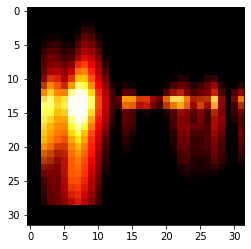

In [23]:
from data.utils_plot import check_cifar100_dataloader
check_cifar100_dataloader(val_dataloader)

In [9]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
logs = [[] for _ in range(NUM_RUNS)]

for run_i in range(NUM_RUNS):
    net = resnet32()
    
    criterion = nn.CrossEntropyLoss()
    
    for split_i in range(10):
        print(f"## Split {split_i} of run {run_i} ##")

        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

        manager = Trainer(DEVICE, net, criterion, optimizer, scheduler,
                          train_dataloader[run_i][split_i],
                          val_dataloader[run_i][split_i],
                          test_dataloader[run_i][split_i])

        scores = manager.train(NUM_EPOCHS)  # train the model

        logs[run_i].append({})

        # score[i] = dictionary with key:epoch, value: score
        logs[run_i][split_i]['train_loss'] = scores[0]
        logs[run_i][split_i]['train_accuracy'] = scores[1]
        logs[run_i][split_i]['val_loss'] = scores[2]
        logs[run_i][split_i]['val_accuracy'] = scores[3]

        # Test the model on classes seen until now
        test_accuracy, all_targets, all_preds = manager.test()

        logs[run_i][split_i]['test_accuracy'] = test_accuracy
        logs[run_i][split_i]['conf_mat'] = confusion_matrix(all_targets.to('cpu'), all_preds.to('cpu'))

        # Add 10 nodes to last FC layer
        manager.increment_classes(n=10)

## Split 0 of run 0 ##
Epoch: 1, LR: [2]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


output: tensor([[ 0.9194, -0.9590,  0.7439, -0.9826, -0.2627, -1.0050,  0.7887,  0.6696,
          2.1407,  0.1130],
        [ 0.3057, -0.9949,  0.1400, -0.2803, -0.0398, -0.2558,  0.2307,  0.8007,
          1.3077,  0.1453],
        [ 0.1413, -1.0062,  0.2902, -0.3347, -0.1481, -0.2450,  0.2323,  0.6183,
          1.4084,  0.2393],
        [ 0.2985, -0.8117,  0.1122, -0.5369, -0.1188, -0.2595,  0.1364,  0.7010,
          1.1449,  0.2312],
        [ 0.3061, -0.9256,  0.3193, -0.3967, -0.1577, -0.2140,  0.3303,  0.6258,
          1.3368,  0.0913],
        [ 0.8168, -0.7340,  0.3187, -0.7376, -0.0913, -0.7567,  0.5063,  0.5420,
          1.8608,  0.1010],
        [ 0.1215, -0.9279,  0.2693, -0.1525,  0.0083, -0.2568,  0.2589,  0.7401,
          1.2438,  0.2118],
        [ 0.2736, -0.9361,  0.2965, -0.3977, -0.0612, -0.0936,  0.3126,  0.5906,
          1.3916,  0.2055],
        [ 0.7158, -0.6735,  0.2820, -0.7241, -0.1995, -0.7049,  0.4589,  0.5945,
          1.4419,  0.0591],
        [ 0

RuntimeError: ignored

In [15]:
list = [73, 72, 74, 58, 35, 20, 19, 80, 28, 90, 17, 35, 27, 18, 38, 11, 65, 36,
         2, 40, 10, 34, 80, 13, 15, 16, 67, 10, 60, 41, 64, 67, 64, 24, 61, 72,
        35, 67, 33,  5, 86,  3, 38, 92,  4, 43, 24, 80, 20, 25, 71, 65, 26, 70,
         8, 34, 21, 96, 10, 82,  4,  5, 34, 81]

ins = set(list)
len(ins)

46

In [65]:
train_data[indexes_train_data[0][0]]


(142, tensor([[[-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          ...,
          [ 0.7578,  0.8164,  0.8457,  ..., -1.8957, -1.8957, -1.8957],
          [ 0.5525,  0.5525,  0.6698,  ..., -1.8957, -1.8957, -1.8957],
          [ 0.3913,  0.4939,  0.6258,  ..., -1.8957, -1.8957, -1.8957]],
 
         [[-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
          ...,
          [ 1.1603,  1.1603,  1.1756,  ..., -1.8975, -1.8975, -1.8975],
          [ 0.9615,  0.9157,  1.0227,  ..., -1.8975, -1.8975, -1.8975],
          [ 0.8239,  0.9310,  1.0686,  ..., -1.8975, -1.8975, -1.8975]],
 
         [[-1.5965, -1.5965, -1.5965,  ..., -1.5965, -1.5965, -1.5965],
          [-1.5965, -1.

In [68]:
tot = set([])
for i in range(5000):
  idx = indexes_train_data[1][i]
  lbl = train_data[idx][2]
  tot.add(lbl)

tot

{10, 11, 12, 13, 14, 15, 16, 17, 18, 19}